# GiveDirectly Take Home Assessment

## Question 1

1. Please evaluate the data in recipients.csv and survey_attempts.csv to answer the following questions:
    1. How many recipients are in each of the four stages? Please provide the calculation(s) in the spreadsheet or code that you submit.
    2. How many surveys were successfully completed in December, 2020? Please provide the calculation(s) in the spreadsheet or code that you submit.
    3. Did you find any abnormalities in the source data? If so, how did you account for them in your analysis?

First install the required packages.

In [1]:
!pip install -r requirements.txt

Import the required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('QtAgg')

import statsmodels.formula.api as smf
import missingno as msno
from sklearn.impute import SimpleImputer

Let's now import the two datasets and merge them

In [3]:
recipients = pd.read_csv('recipients.csv')
attempts = pd.read_csv('survey_attempts.csv')
merged = pd.merge(recipients, attempts, on='recipient_id', how='left', indicator=True)
merged._merge.value_counts(dropna=False)


both          520
left_only       0
right_only      0
Name: _merge, dtype: int64

It looks like all the recipients are matched with survey attempts. We can drop the `_merge` variable

In [4]:
merged.drop(columns='_merge', inplace=True)

A quick glance at our data

In [5]:
merged.head(10)

,recipient_id,county,time_county,age,account_number,account_status,survey_id,date,success
0,r-00085,County B,22.0,22.0,100000022.0,NaN,s-000342,12/23/20,True
1,r-00085,County B,22.0,22.0,100000022.0,NaN,s-000448,11/25/20,False
2,r-00082,County C,29.0,31.0,100000023.0,Not Active,s-000151,12/20/20,True
3,r-00082,County C,29.0,31.0,100000023.0,Not Active,s-000305,11/22/20,False
4,r-00048,County C,22.0,24.0,100000035.0,Active,s-000108,11/28/20,False
5,r-00048,County C,22.0,24.0,100000035.0,Active,s-000116,01/17/21,True
6,r-00048,County C,22.0,24.0,100000035.0,Active,s-000439,11/18/20,False
7,r-00096,County B,22.0,25.0,100000166.0,Active,s-000077,11/06/20,False
8,r-00096,County B,22.0,25.0,100000166.0,Active,s-000130,01/03/21,True
9,r-00064,County D,24.0,26.0,100000076.0,Active,s-000352,11/04/20,False


Check for duplicates. We expect that `recipient_id` and `survey_id` together form a unique id.


In [6]:
merged[merged.duplicated(subset=['recipient_id', 'survey_id'], keep=False)]

,recipient_id,county,time_county,age,account_number,account_status,survey_id,date,success
15,r-00100,County C,30.0,32.0,100000107.0,Active,s-000045,11/10/20,False
17,r-00100,County C,30.0,32.0,100000107.0,Active,s-000045,11/10/20,False
19,r-00030,County C,23.0,26.0,100000179.0,Active,s-000036,11/10/20,False
22,r-00030,County C,23.0,26.0,100000179.0,Active,s-000036,11/10/20,False
28,r-00193,County B,10.0,62.0,100000977.0,Active,s-000018,01/22/21,False
...,...,...,...,...,...,...,...,...,...
506,r-00191,County B,10.0,62.0,100000126.0,Active,s-000026,12/11/20,False
510,r-00036,County C,32.0,32.0,100000183.0,Active,s-000003,11/16/20,False
513,r-00036,County C,32.0,32.0,100000183.0,Active,s-000003,11/16/20,False
518,r-00122,County A,8.0,49.0,100000013.0,Not Active,s-000005,01/29/21,True


There are 50 pairs of duplicates that need to be dropped.  

In [7]:
merged = merged.drop_duplicates(subset=['recipient_id', 'survey_id'], keep='first').reset_index(drop=True)


Let's now calculate the stage variable, starting with 'Start'.

In [8]:
mask = merged.groupby('recipient_id')['success'].any()
one_success = [mask.index[i] for i, m in enumerate(mask) if m]
# Set the value to start for those with no successful surveys. '~' negates the value 
# of the mask. In this case, ~mask means find those without any successful survey
merged.loc[~merged.recipient_id.isin(one_success), 'stage'] = 'Start'

Next, the 'Ineligible' stage

In [9]:
# Remove the text 'County' from the column
merged.county = merged.county.str.replace('County ', '', regex=False)
    
inABC = merged.county.isin(['A', 'B', 'C'])
recipient_noABC = merged.recipient_id[~inABC]

merged.loc[merged.recipient_id.isin(one_success) &
    merged.recipient_id.isin(recipient_noABC), 'stage'] = 'Ineligible'

The 'Review' stage

In [10]:
recipient_yesABC = merged.recipient_id[inABC]
notActive = merged.account_status == 'Not Active'
recipient_notActive = merged.recipient_id[notActive]

merged.loc[merged.recipient_id.isin(one_success) &
           merged.recipient_id.isin(recipient_yesABC) &
           merged.recipient_id.isin(recipient_notActive),
           'stage'] = 'Review'

And finally the 'Pay' stage

In [11]:
active = merged.account_status == 'Active'
recipient_active = merged.recipient_id[active]
merged.loc[merged.recipient_id.isin(one_success) &
           merged.recipient_id.isin(recipient_yesABC) &
           merged.recipient_id.isin(recipient_active), 'stage'] = 'Pay'

### 1.1 How many recipients in each stage?

In [12]:
merged.stage.value_counts(dropna=False)

Pay           209
Start         150
Ineligible     70
Review         35
NaN             6
Name: stage, dtype: int64

There are 209 in the 'Pay' stage, 150 in the 'Start', 150 'Ineligible', 35 in 'Review', and 6 not in any stage.
This is because there are 6 recipients with a missing `account_status`. 

In [13]:
merged.loc[merged.stage.isna()]

,recipient_id,county,time_county,age,account_number,account_status,survey_id,date,success,stage
0,r-00085,B,22.0,22.0,100000022.0,NaN,s-000342,12/23/20,True,NaN
1,r-00085,B,22.0,22.0,100000022.0,NaN,s-000448,11/25/20,False,NaN
14,r-00145,A,22.0,24.0,100000089.0,NaN,s-000137,12/21/20,True,NaN
50,r-00045,C,26.0,30.0,100000199.0,NaN,s-000161,11/25/20,False,NaN
51,r-00045,C,26.0,30.0,100000199.0,NaN,s-000236,11/15/20,False,NaN
52,r-00045,C,26.0,30.0,100000199.0,NaN,s-000337,01/14/21,True,NaN


We could assign these recipients to a 'Not Active' `account_status`,
but it is important to follow up with someone for the appropriate status.

### 1.2 How many successful surveys in December?

In [14]:
merged['month'] = merged['date'].astype(str).str[:2]
merged.groupby('month')['success'].sum()

month
01    77
11     0
12    93
Name: success, dtype: int64

There were 93 successful surveys in December.

### 1.3 Abnormalities in the source data

There were duplicates in the data that had to be dropped. Some values also did not make much sense and were dropped.

In [15]:
merged.describe()

,time_county,age,account_number
count,455.000000,460.000000,4.630000e+02
mean,19.138462,124.126087,1.000001e+08
std,10.501550,925.986058,1.074233e+02
min,-45.000000,20.000000,1.000000e+08
25%,10.000000,25.000000,1.000001e+08
50%,21.000000,32.000000,1.000001e+08
75%,28.000000,51.000000,1.000002e+08
max,35.000000,9999.000000,1.000010e+08


`time_county` has a minimum of -45 and `age` has a max of 9999. To deal with these problematic cases, I replace them with the median value for the `county`. It could also be good to follow up with other teams on the correct value.

In [16]:

merged.age[merged.age == 9999] = merged.groupby('county')['age'].transform(
    lambda x: x.median()
)
merged.time_county[merged.time_county < 0] = merged \
    .groupby('county')['time_county'] \
    .transform(lambda x: x.median())


/tmp/ipykernel_14654/1659890157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.age[merged.age == 9999] = merged.groupby('county')['age'].transform(
/tmp/ipykernel_14654/1659890157.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.time_county[merged.time_county < 0] = merged \


There are missing values in the data as well.

In [17]:
merged.isna().sum()

recipient_id       0
county             8
time_county       15
age               10
account_number     7
account_status    13
survey_id          0
date               0
success            0
stage              6
month              0
dtype: int64

6 columns have missing data.

Missing data is usually deleted or imputed. Deleting missing data is easiest, but it can lead to biases if the data is not missing at random. If `age` is more likely to be missing in certain counties, for example, deleting missing data isn't the best approach. If the data is missing completely at random or missing at random, it can be deleted.

If there are many missing values in a row, the row can be deleted. Likewise, if there are many missing values in a column, the column can be deleted. 

Imputation can be as simple as replacing the missing value in a column with an arbitrary value such as '0' or the column mean or mode. Other techniques take into account the values in other columns. Suppose a recipient has a missing `age`, but lives in a certain county and has also responded to the survey. Then the `age` might be imputed to be slightly lower because of a correlation between `success` and `age` or `county` and `age`. See more [here](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/#h2_2).

We can investigate the missing data with the `missingno` package.

/tmp/ipykernel_14654/2359591310.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


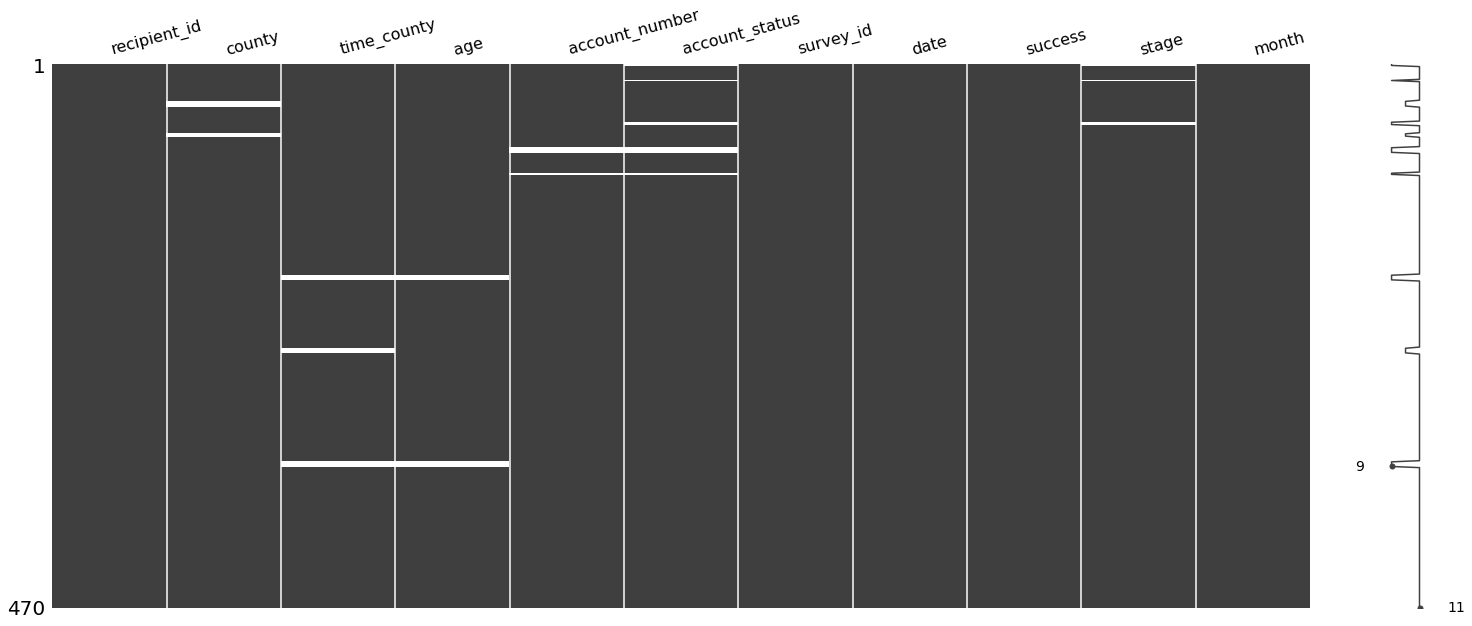

In [18]:
%matplotlib inline

msno.matrix(merged)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

The white lines represent missing values. The `account_number` and `account_status` appear to have coinciding missing values, and the same for `age` and `time_county`. We can visualize these relationships with a heatmap.

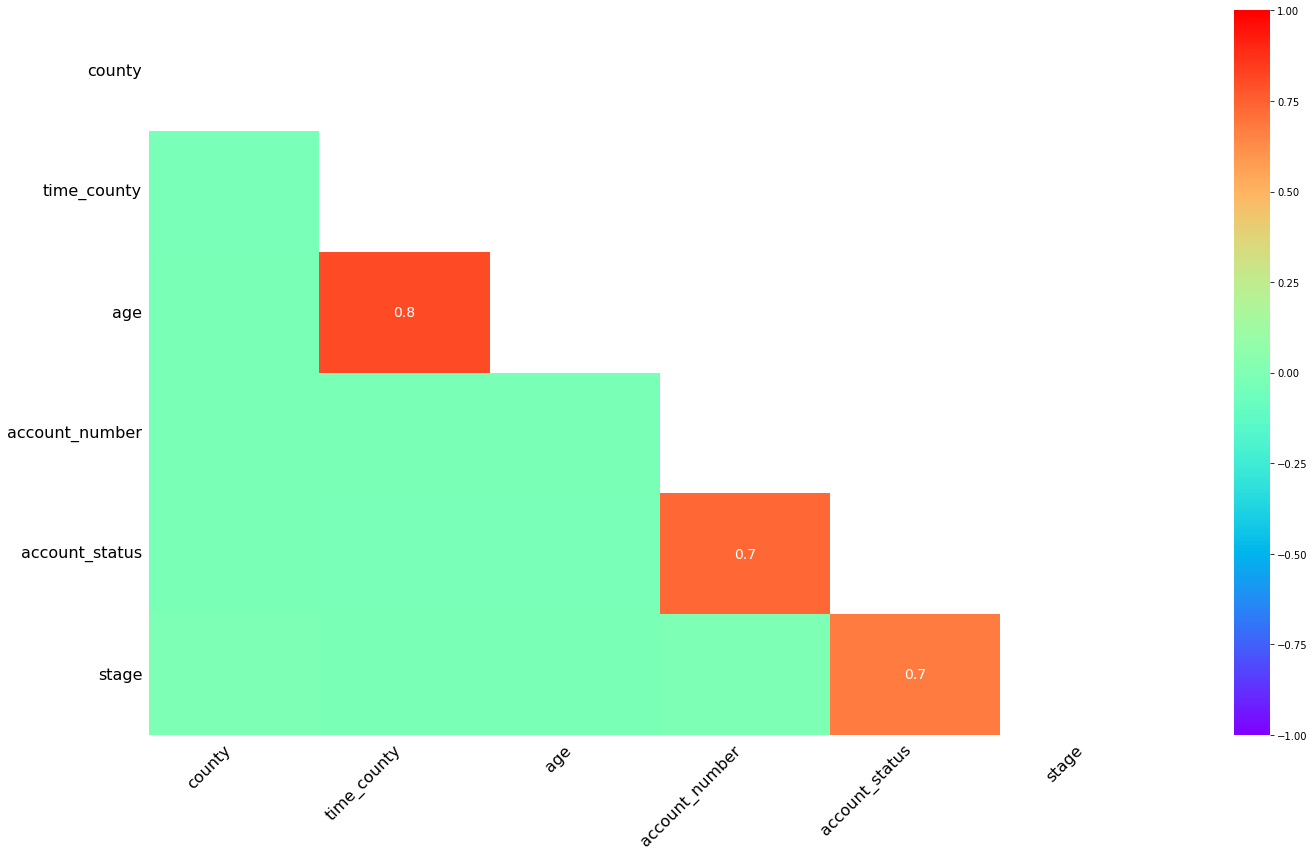

In [19]:
%matplotlib inline

msno.heatmap(merged, cmap='rainbow')
plt.tight_layout()
plt.show()

There is a strong correlation between `account_number` and `account_status` being missing, which
would make sense considering that someone without an `account_number` would not have 
an `account_status` and vice versa. There is also a strong association between `age` and `time_county` missingness.

To investigate this, let's look at recipients with a missing `age`.

In [20]:
time_county_missing = merged.loc[merged.time_county.isna()]
age_missing = merged.loc[merged.age.isna()]
print(time_county_missing)

    recipient_id county  time_county   age  account_number account_status  \
182      r-00198      B          NaN   NaN     100000006.0         Active   
183      r-00198      B          NaN   NaN     100000006.0         Active   
184      r-00198      B          NaN   NaN     100000006.0         Active   
185      r-00198      B          NaN   NaN     100000006.0         Active   
186      r-00198      B          NaN   NaN     100000006.0         Active   
245      r-00171      A          NaN  58.0     100000121.0         Active   
246      r-00171      A          NaN  58.0     100000121.0         Active   
247      r-00171      A          NaN  58.0     100000121.0         Active   
248      r-00171      A          NaN  58.0     100000121.0         Active   
249      r-00171      A          NaN  58.0     100000121.0         Active   
343      r-00173      A          NaN   NaN     100000029.0         Active   
344      r-00173      A          NaN   NaN     100000029.0         Active   

In [21]:
print(age_missing)

    recipient_id county  time_county  age  account_number account_status  \
182      r-00198      B          NaN  NaN     100000006.0         Active   
183      r-00198      B          NaN  NaN     100000006.0         Active   
184      r-00198      B          NaN  NaN     100000006.0         Active   
185      r-00198      B          NaN  NaN     100000006.0         Active   
186      r-00198      B          NaN  NaN     100000006.0         Active   
343      r-00173      A          NaN  NaN     100000029.0         Active   
344      r-00173      A          NaN  NaN     100000029.0         Active   
345      r-00173      A          NaN  NaN     100000029.0         Active   
346      r-00173      A          NaN  NaN     100000029.0         Active   
347      r-00173      A          NaN  NaN     100000029.0         Active   

    survey_id      date  success  stage month  
182  s-000284  01/07/21    False  Start    01  
183  s-000285  12/08/20    False  Start    12  
184  s-000311  12/1

In [22]:
print(time_county_missing.equals(age_missing))

False


In [23]:
time_county_missing.recipient_id.nunique()

3

So `age` is missing exactly when `time_county` is missing. There are two recipients that did not fill in these questions for multiple survey attempts. They may have been uncomfortable sharing that information.

Dropping these records could lead to bias because they are not missing at random. Let's impute the `age` and `time_county` for them. But first let's impute the missing `county` instances. `county` is a categorical variable, so the most frequent value will be imputed. We'll also impute `account_status`, another categorical variable. Note that there are other ways of imputation that take into account other columns in the data.

In [24]:
imp = SimpleImputer(strategy='most_frequent')

In [25]:
merged[['county', 'account_status']] = imp.fit_transform(merged[['county', 'account_status']])

Now that the `county` has been imputed, the `age` will be imputed as the median age for that `county`. The same procedure will also work for `time_county`.

In [26]:
merged.age = merged.groupby('county')['age'].transform(
    lambda x: x.fillna(x.median()))

merged.time_county = merged.groupby('county')['time_county'].transform(
        lambda x: x.fillna(x.median())
    )

`account_number` will not be imputed because it is not needed for analysis. Note that once the `account_status` is imputed, the `stage` variable can be recalculated because the six missing cases were missing because of the missing `account_status` at the time of calculation.

In [27]:
notActive = merged.account_status == 'Not Active'
recipient_notActive = merged.recipient_id[notActive]

merged.loc[merged.recipient_id.isin(one_success) &
           merged.recipient_id.isin(recipient_yesABC) &
           merged.recipient_id.isin(recipient_notActive),
           'stage'] = 'Review'

In [28]:
active = merged.account_status == 'Active'
recipient_active = merged.recipient_id[active]
merged.loc[merged.recipient_id.isin(one_success) &
           merged.recipient_id.isin(recipient_yesABC) &
           merged.recipient_id.isin(recipient_active), 'stage'] = 'Pay'

And now we can re-check which columns contain missing data

In [29]:
merged.isna().sum()

recipient_id      0
county            0
time_county       0
age               0
account_number    7
account_status    0
survey_id         0
date              0
success           0
stage             0
month             0
dtype: int64

There is only the `account_number` column, which can be ignored for analysis.

## Question 2

2. The program manager has asked for data to help determine whether the field team should focus more effort on calling those in stage Start or following up to resolve issues with those in stage Review. Please write a response to the program manager, including data that may help inform the decision, and some additional factors that you would take into consideration to make the decision. Assume that the program manager’s expertise does not include interpreting data and complex analytics. Please limit your written response to 300 words or less. 

It would not make sense to calculate the chance of someone having a successful survey based on the `stage` variable because the 'Start' group would have no successful surveys and the other three groups would have 100% successful surveys. On the other hand, it would be good to know the chances of someone moving from the 'Review' stage to a 'Pay' stage at a later date, for example. 

In [30]:
# Check how many recipients have more than one stage
(merged.groupby('recipient_id')['stage'].nunique() > 1).sum()

0

There do not appear to be recipients that have changed their stage. Let's check for recipients
that have changed from 'Not Active' to 'Active' `account_status`.

In [31]:
(merged.groupby('recipient_id')['account_status'].nunique() > 1).sum()

0

No recipients have changed from 'Not Active' to 'Active' `account_status` either.


One thing to consider is that the 'Start' group has 150 recipients compared to only 35 in the 'Review' group.
The 'Start' group success rate only needs to be 35/150 ~ 23% to match a 100% success rate in the
'Review' group. It would be good to look up historical data on the conversion rate from 'Start' to 'Pay' versus 'Review' to 'Pay'. Data on the cost of converting the 'Start' group versus the 'Review' group would also be helpful for the decision.

In [32]:
merged.stage.value_counts(dropna=False)

Pay           215
Start         150
Ineligible     70
Review         35
Name: stage, dtype: int64

## Question 3

3. The country director is considering investing resources into proactively conducting in-person surveys with recipients *in the highest age group* across projects to increase overall survey success rate. They believe that this additional cost might outweigh the current costs of repeated failed phone survey attempts, if we can accurately target those recipients *least likely* to respond to a phone survey. 
    1. What analysis would you provide from the provided project data to help make this decision? Please provide the calculation(s) in the spreadsheet or code that you submit.
    2. Are there other factors that might explain the observed survey success rate from this project? Please use your judgment to determine these factors and limit your written response to 400 words or less. 

### 3.1

Let's graph the relationship between `age` and at least one successful survey.

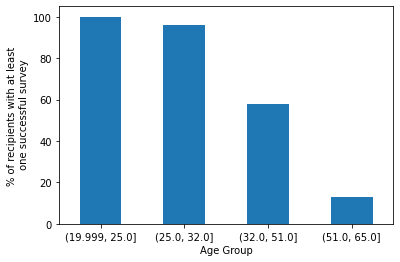

In [33]:
%matplotlib inline

merged['one_success'] = 0
merged.loc[merged.recipient_id.isin(one_success), 'one_success'] = 1

# Create bins for age broken into quartiles
merged['age_bin'] = pd.qcut(merged.age, q=4)
age_success = merged.groupby('age_bin')['one_success'].sum()
age = merged.groupby('age_bin')['one_success'].count()
results = age_success.div(age, level='age_bin') * 100

results.plot(kind='bar')

plt.xticks(rotation=0)
plt.xlabel('Age Group')
plt.ylabel('% of recipients with at least\n one successful survey')
plt.show()

People in the highest age group are the least likely to have at least one successful survey.

Using logistic regression we have

In [34]:
logit = smf.logit('one_success ~ age', data=merged).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.263246
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            one_success   No. Observations:                  470
Model:                          Logit   Df Residuals:                      468
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.5796
Time:                        21:02:47   Log-Likelihood:                -123.73
converged:                       True   LL-Null:                       -294.33
Covariance Type:            nonrobust   LLR p-value:                 3.494e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3413      0.673     12.402      0.000       7.023       9.660
age           -0.1838      0.

There is a negative relationship between `age` and the chance of at least one successful survey. The coefficient is also statistically significant. To interpret it we calculate the odds ratio.

In [35]:
odds_ratios = pd.DataFrame({
        'OR': logit.params, 
        'Lower CI': logit.conf_int()[0],
        'Upper CI': logit.conf_int()[1]
    })
    
odds_ratios = pd.np.exp(odds_ratios)
print(odds_ratios)
print(round((odds_ratios['OR'][1] - 1) * 100, 2))

                    OR     Lower CI      Upper CI
Intercept  4193.470574  1122.196761  15670.331683
age           0.832141     0.807835      0.857177
-16.79


/tmp/ipykernel_14654/4211037893.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  odds_ratios = pd.np.exp(odds_ratios)


Each additional increase of one year in age is associated with a roughly 17 percent decrease
in odds of having at least one successful survey. 

So far, it appears that older recipients are less likely to respond to surveys. Focusing on the 
older recipients would help target those with lower response rates.

### 3.2

We include other variables in our logistic regression to check for confounders.

In [50]:
big_logit = smf.logit('one_success ~ time_county + age + C(month) + C(account_status)', data=merged).fit()
print(big_logit.summary())

         Current function value: 0.021792
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            one_success   No. Observations:                  470
Model:                          Logit   Df Residuals:                      464
Method:                           MLE   Df Model:                            5
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.9652
Time:                        21:21:51   Log-Likelihood:                -10.242
converged:                      False   LL-Null:                       -294.33
Covariance Type:            nonrobust   LLR p-value:                1.523e-120
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           7.2573      4.887      1.485      0.137      -2.320      16.835
C(

/home/dylan/give-directly-exercise/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


When `time_county` and `month` and `account_status` are included along with `age`, `age` and `time_county` are still  significant predictors. We can also look at other feature selection tools.